In [2]:
from src.components.nn_data_ingestion import FraudDetectionDataset
from src.baseline.data_ingestion import DataIngestorFactory, DataIngestorConfig
from torch.utils.data import DataLoader
from pytorch_lightning.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint  # Updated import
from src.utils import setup_logger, seed_everything
from src.exception import CustomException
from src.baseline.features_engineering import PreprocessorPipeline
import pandas as pd
import os
import matplotlib.pyplot as plt



In [10]:

os.chdir(rf"c:\Users\thuhi\workspace\fraud_detection")
print(os.getcwd())

factory = DataIngestorFactory()
ingestor = factory.create_ingestor("duration_pkl")
train_df, validation_df = ingestor.ingest(
    dir_path=rf"C:\Users\thuhi\workspace\fraud_detection\data\transformed_data",
    start_train_date="2018-06-01",
    train_duration=1,
    test_duration=30,
    delay=7
)



c:\Users\thuhi\workspace\fraud_detection


In [11]:

validation_preprocessed = validation_df.copy()
validation_preprocessed.dtypes

TRANSACTION_ID                                  int64
TX_DATETIME                            datetime64[ns]
CUSTOMER_ID                                     int64
TERMINAL_ID                                     int64
TX_AMOUNT                                     float64
TX_TIME_SECONDS                                 int64
TX_TIME_DAYS                                    int64
TX_FRAUD                                        int64
TX_FRAUD_SCENARIO                               int64
TX_DURING_WEEKEND                               int64
TX_DURING_NIGHT                                 int64
CUSTOMER_ID_NB_TX_1DAY_WINDOW                 float64
CUSTOMER_ID_AVG_AMOUNT_1DAY_WINDOW            float64
CUSTOMER_ID_NB_TX_7DAY_WINDOW                 float64
CUSTOMER_ID_AVG_AMOUNT_7DAY_WINDOW            float64
CUSTOMER_ID_NB_TX_30DAY_WINDOW                float64
CUSTOMER_ID_AVG_AMOUNT_30DAY_WINDOW           float64
TERMINAL_ID_NB_TX_1DAY_WINDOW                 float64
TERMINAL_ID_RISK_1DAY_WINDOW

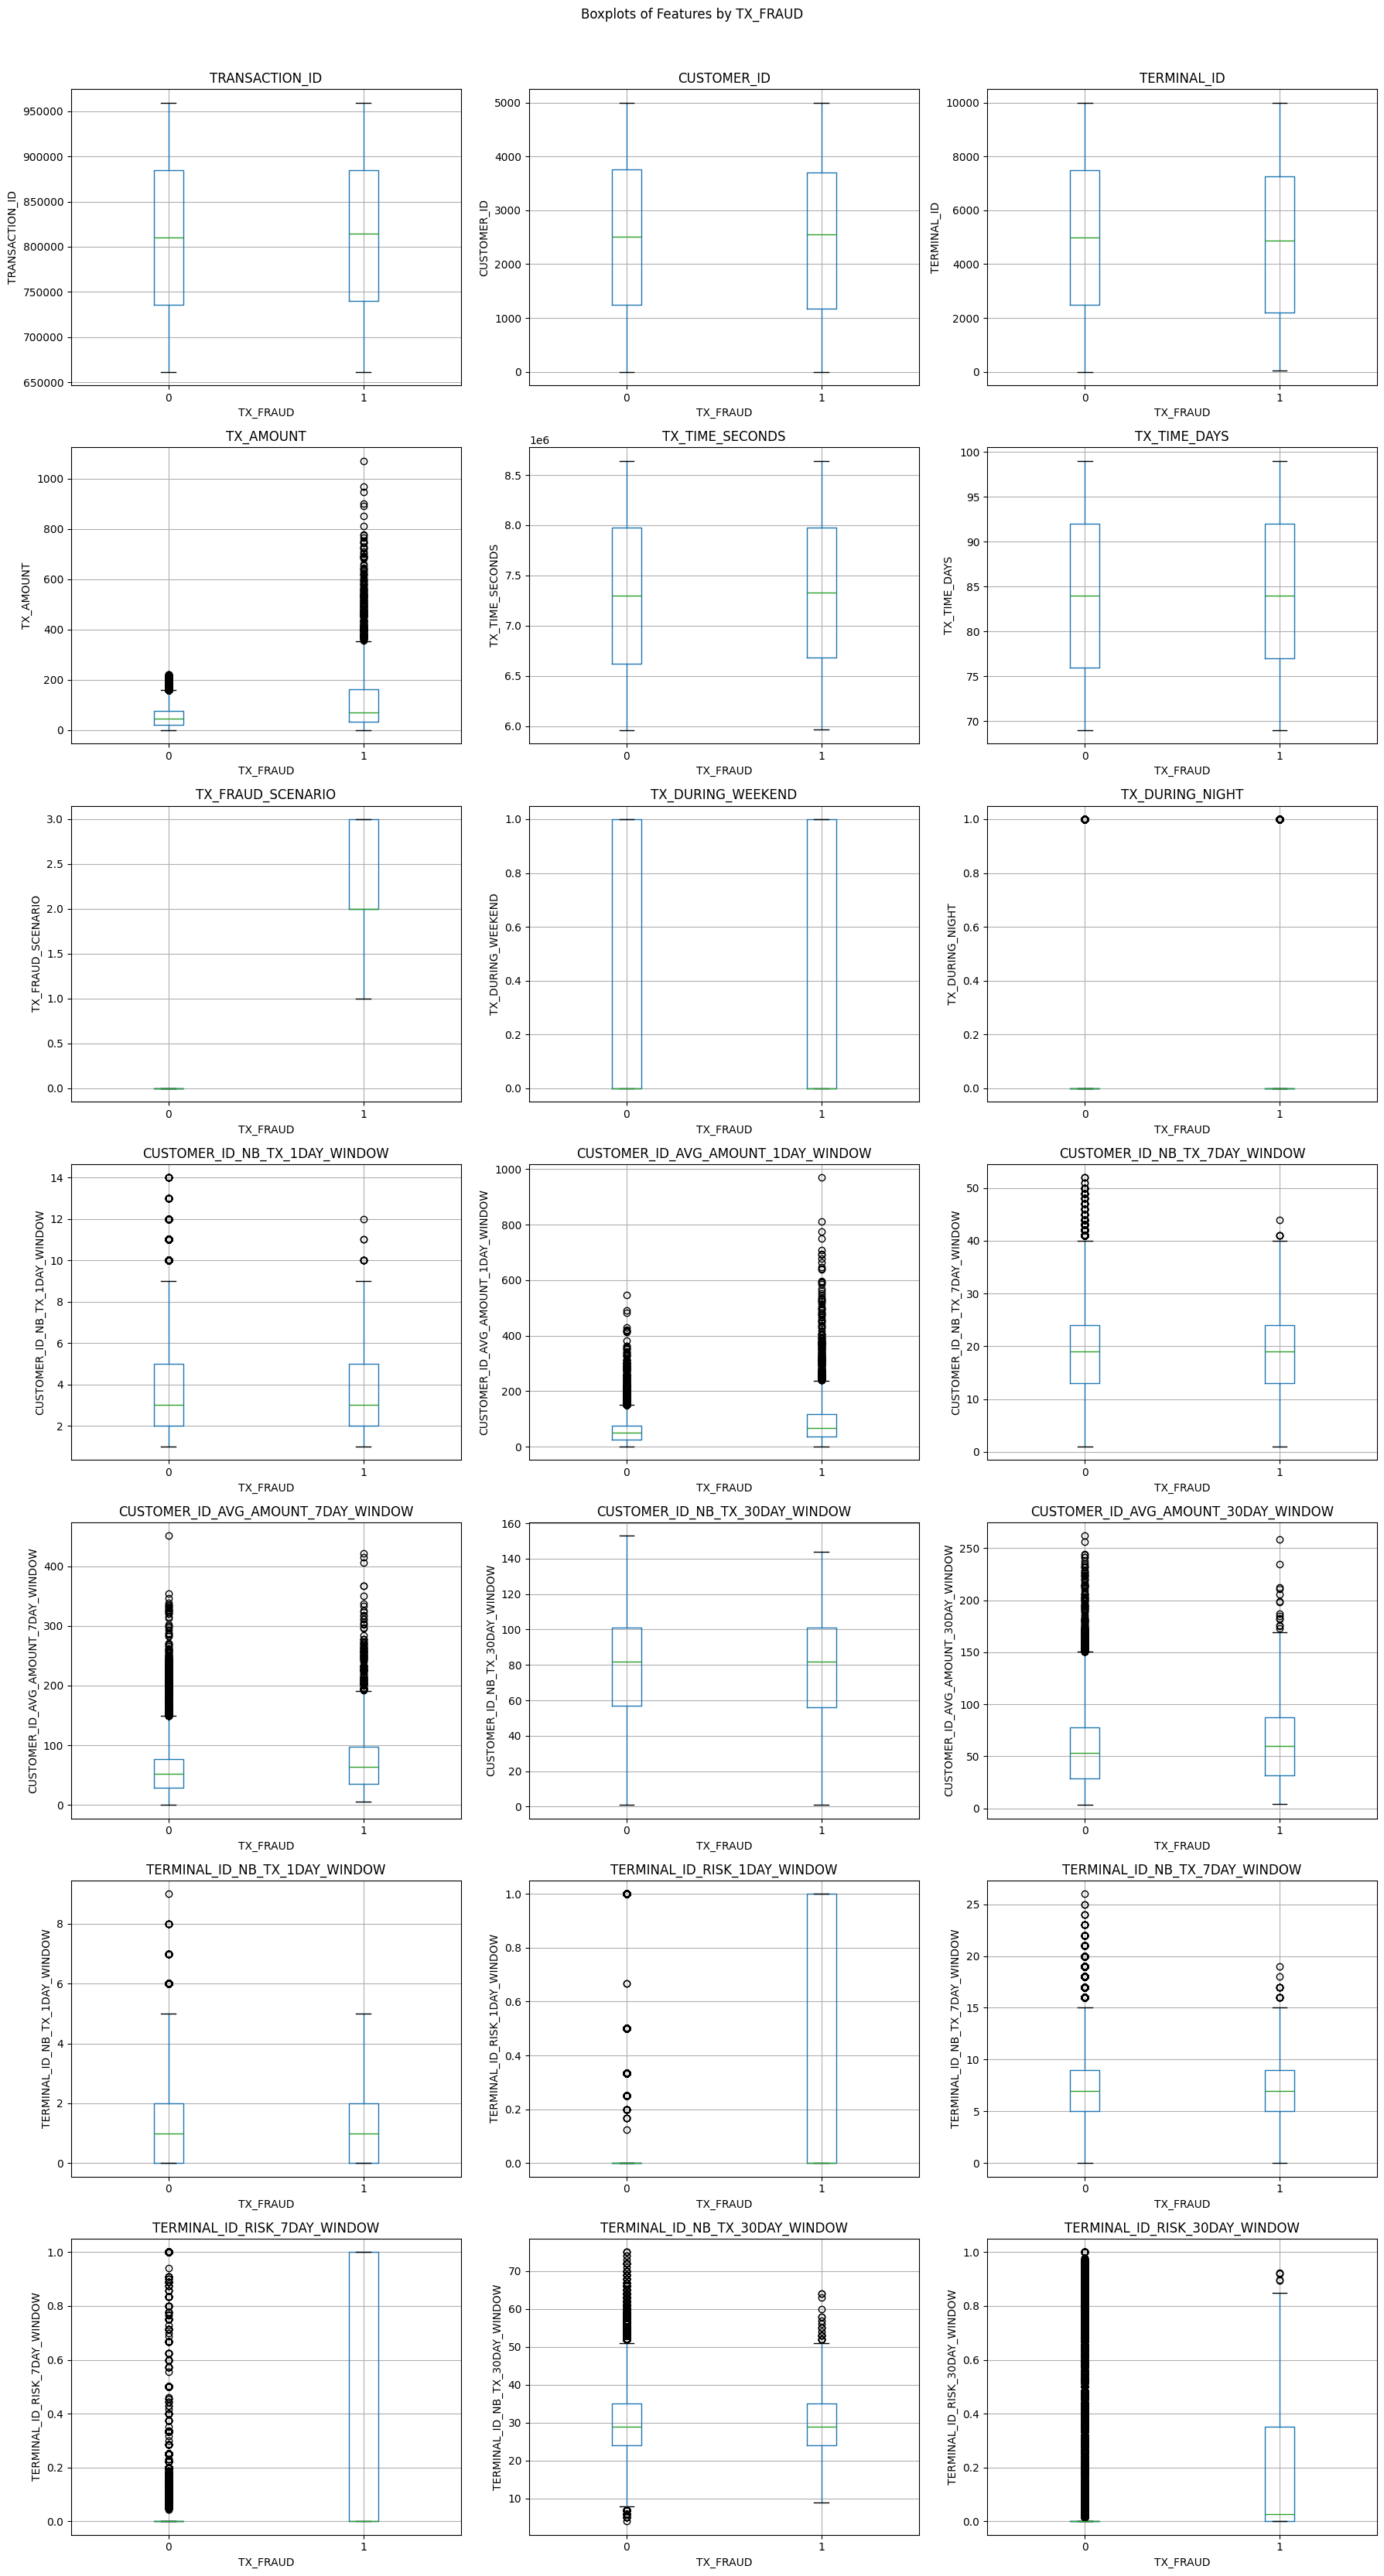

In [12]:


# Exclude non-numeric columns and 'TX_FRAUD' itself from features to plot
features = [col for col in validation_preprocessed.columns if col not in ['TX_FRAUD'] and pd.api.types.is_numeric_dtype(validation_preprocessed[col])]

n_features = len(features)
fig, axes = plt.subplots(nrows=(n_features + 2) // 3, ncols=3, figsize=(18, 5 * ((n_features + 2) // 3)))
axes = axes.flatten()

for i, feature in enumerate(features):
    validation_preprocessed.boxplot(column=feature, by='TX_FRAUD', ax=axes[i])
    axes[i].set_title(feature)
    axes[i].set_xlabel('TX_FRAUD')
    axes[i].set_ylabel(feature)

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Boxplots of Features by TX_FRAUD')
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

C:\Users\thuhi\AppData\Local\Temp\ipykernel_6864\1589901388.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = validation_preprocessed.groupby(['binned_feature', 'TX_FRAUD']).size().unstack(fill_value=0)
C:\Users\thuhi\AppData\Local\Temp\ipykernel_6864\1589901388.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = validation_preprocessed.groupby(['binned_feature', 'TX_FRAUD']).size().unstack(fill_value=0)
C:\Users\thuhi\AppData\Local\Temp\ipykernel_6864\1589901388.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas.

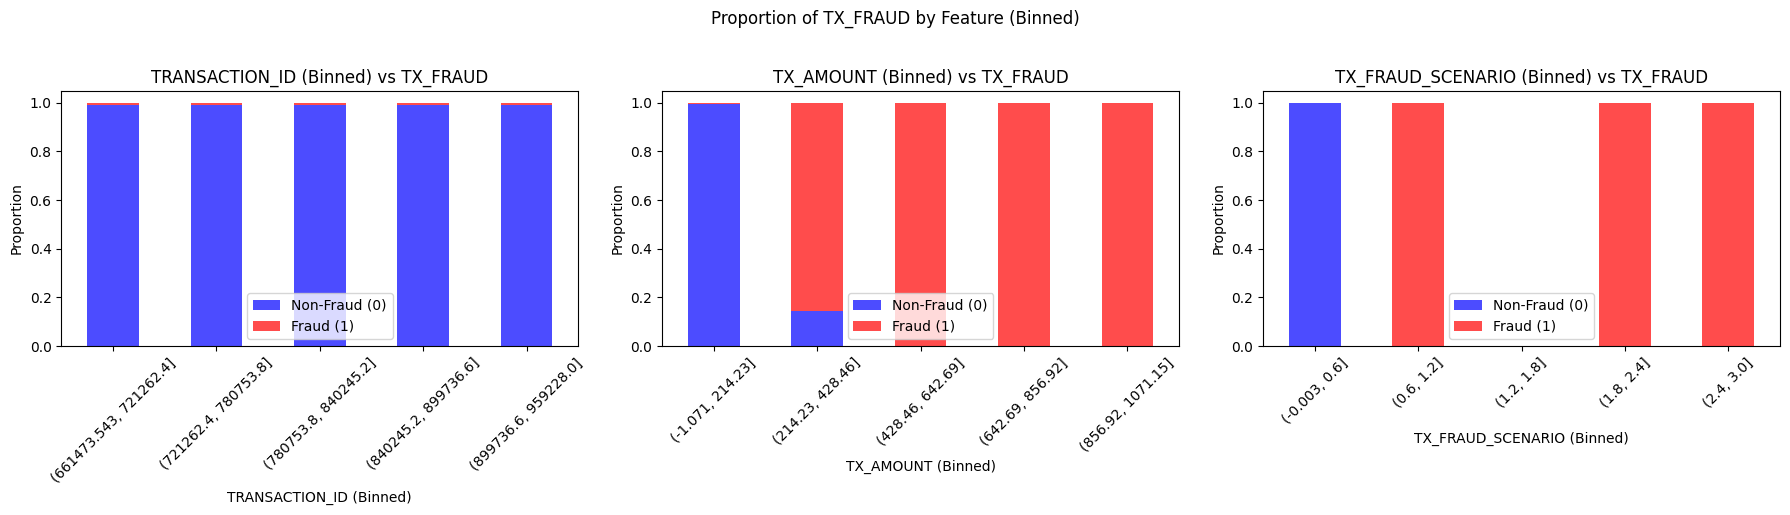

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Exclude non-numeric columns and 'TX_FRAUD' itself from features to plot
features = [col for col in validation_preprocessed.columns 
            if col != 'TX_FRAUD' and pd.api.types.is_numeric_dtype(validation_preprocessed[col])]

# Set up the subplot grid
n_features = len(features)
nrows = (n_features + 2) // 3
fig, axes = plt.subplots(nrows=nrows, ncols=3, figsize=(18, 5 * nrows))
axes = axes.flatten()

# Plot stacked bar charts for each feature
for i, feature in enumerate(features):
    # Bin the feature into 5 bins
    validation_preprocessed['binned_feature'] = pd.cut(validation_preprocessed[feature], bins=5)
    
    # Calculate proportion of TX_FRAUD=0 and TX_FRAUD=1 in each bin
    grouped = validation_preprocessed.groupby(['binned_feature', 'TX_FRAUD']).size().unstack(fill_value=0)
    grouped = grouped.div(grouped.sum(axis=1), axis=0)  # Normalize to get proportions
    
    # Plot stacked bar chart
    grouped.plot(kind='bar', stacked=True, ax=axes[i], color=['blue', 'red'], alpha=0.7)
    axes[i].set_title(f'{feature} (Binned) vs TX_FRAUD')
    axes[i].set_xlabel(f'{feature} (Binned)')
    axes[i].set_ylabel('Proportion')
    axes[i].legend(['Non-Fraud (0)', 'Fraud (1)'])
    
    # Rotate x-axis labels for readability
    axes[i].tick_params(axis='x', rotation=45)
    
    # Remove temporary column
    validation_preprocessed.drop(columns='binned_feature', inplace=True)

# Remove empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Proportion of TX_FRAUD by Feature (Binned)', y=1.02)
plt.tight_layout()
plt.show()

In [7]:
va

NameError: name 'va' is not defined

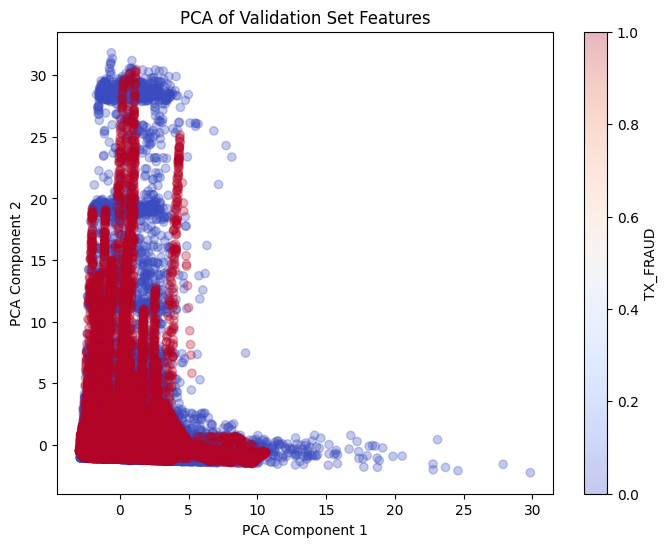

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize features before PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(validation_preprocessed[features])

# Fit PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot PCA result colored by TX_FRAUD
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=validation_preprocessed['TX_FRAUD'], cmap='coolwarm', alpha=0.3)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA of Validation Set Features')
plt.colorbar(label='TX_FRAUD')
plt.show()

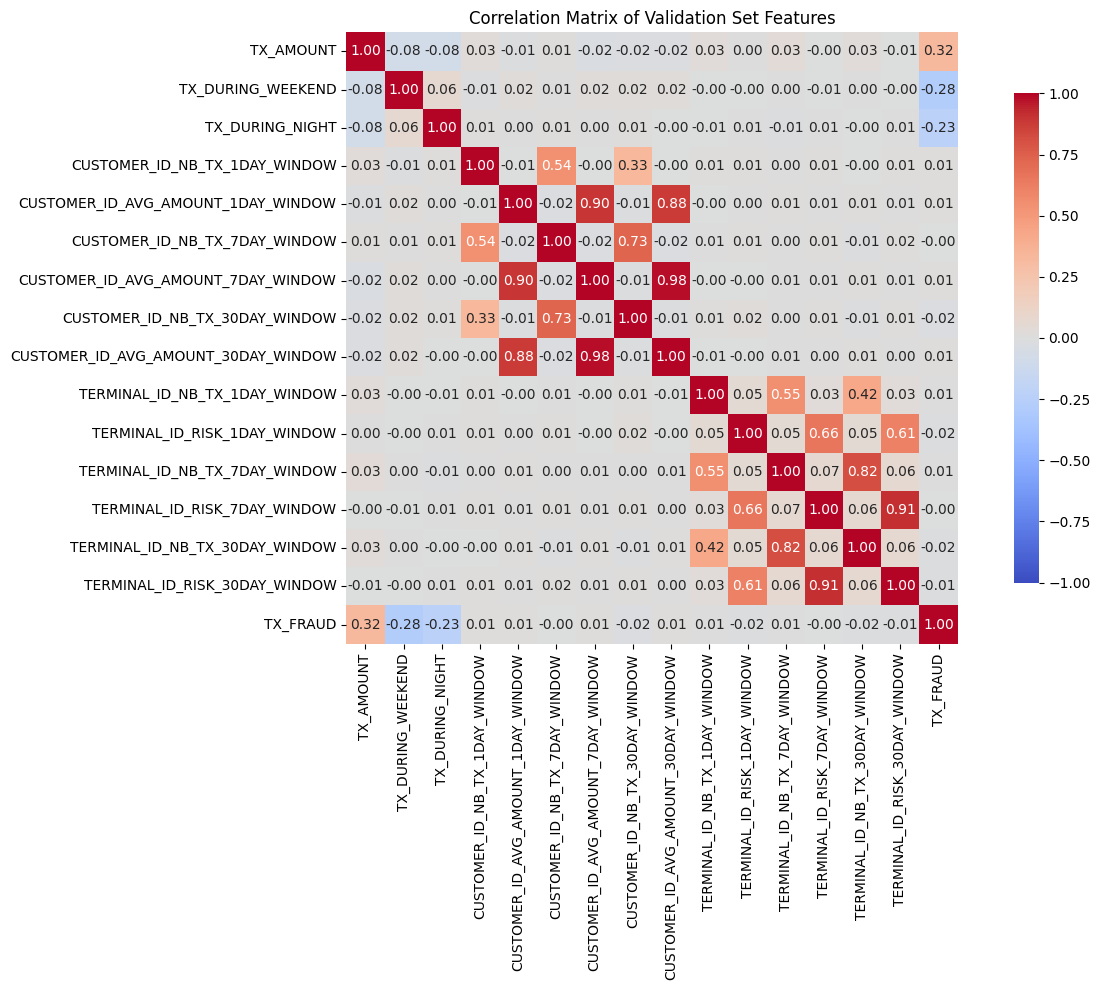

In [ ]:
corr_matrix = validation_preprocessed[features + ['TX_FRAUD']].corr()

import seaborn as sns

plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1, square=True, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix of Validation Set Features')
plt.tight_layout()
plt.show()
